In [8]:
import pandas as pd
from IPython.display import display
from PIL import Image

In [2]:
df = pd.read_csv('./dataset/faceScrub/facescrub_actors.txt', '	')

In [3]:
df.head()

,name,image_id,face_id,url,bbox,sha256
0,Aaron Eckhart,1,1,http://upload.wikimedia.org/wikipedia/commons/...,"53,177,418,542",dec996994cf1eec33b53c203cff0e8f25638829fa2ad71...
1,Aaron Eckhart,2,2,http://movies.dosthana.com/sites/default/files...,"80,102,260,282",f84d0c3b1b854a51e6bc031bc353e801834e81df795e85...
2,Aaron Eckhart,3,3,http://upload.wikimedia.org/wikipedia/commons/...,"203,802,975,1574",8548658ef00f2ac4c384fbfff9d3ae225b4b9e0c2aa45e...
3,Aaron Eckhart,4,4,http://25.media.tumblr.com/nJ2vga5sae9o2ks4Flt...,"62,90,231,259",658d83f35859d2f313ff660c1900427c21eae1c41e3035...
4,Aaron Eckhart,5,5,http://upload.wikimedia.org/wikipedia/commons/...,"276,120,492,336",1fa14fed3371280e8785df42cdc5d0335e7923a38f1b06...


In [4]:
image_url = df.iloc[0]
#Image(filename=df[])
image_url

name                                            Aaron Eckhart
image_id                                                    1
face_id                                                     1
url         http://upload.wikimedia.org/wikipedia/commons/...
bbox                                           53,177,418,542
sha256      dec996994cf1eec33b53c203cff0e8f25638829fa2ad71...
Name: 0, dtype: object

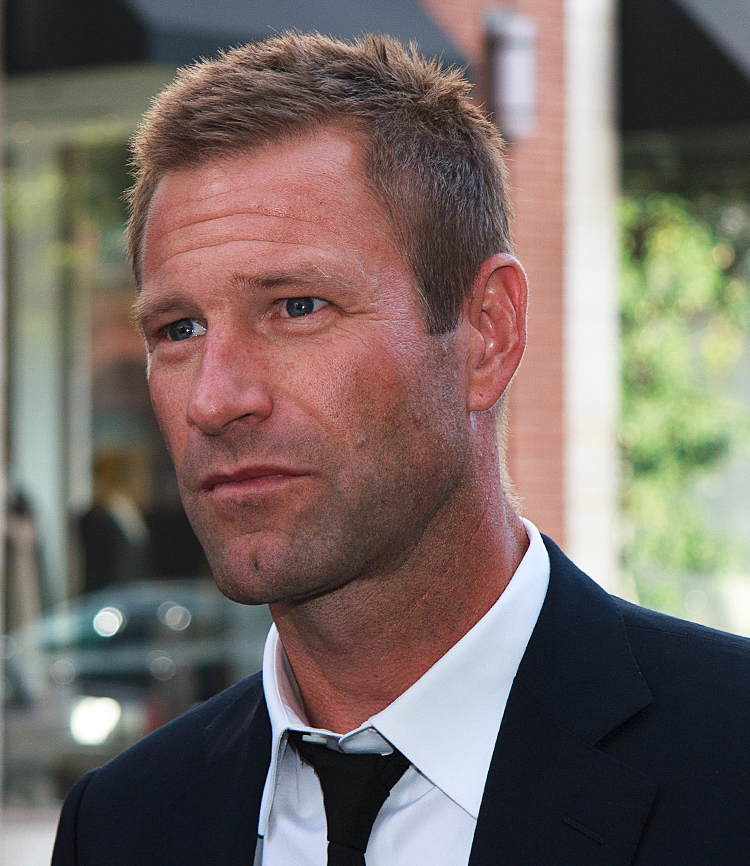

In [15]:
path = image_url.url
from IPython.core.display import Image, display
display(Image(path))


'Face GAN.ipynb'
